In [1]:
def radial_data(data,annulus_width=1,working_mask=None,x=None,y=None,rmax=None):
    """
    From : https://www.astrobetter.com/wiki/python_radial_profiles
    By Ian J Crossfield
    r = radial_data(data,annulus_width,working_mask,x,y)
    
    A function to reduce an image to a radial cross-section.
    
    INPUT:
    ------
    data   - whatever data you are radially averaging.  Data is
            binned into a series of annuli of width 'annulus_width'
            pixels.
    annulus_width - width of each annulus.  Default is 1.
    working_mask - array of same size as 'data', with zeros at
                      whichever 'data' points you don't want included
                      in the radial data computations.
      x,y - coordinate system in which the data exists (used to set
             the center of the data).  By default, these are set to
             integer meshgrids
      rmax -- maximum radial value over which to compute statistics
    
     OUTPUT:
     -------
      r - a data structure containing the following
                   statistics, computed across each annulus:
          .r      - the radial coordinate used (outer edge of annulus)
          .mean   - mean of the data in the annulus
          .std    - standard deviation of the data in the annulus
          .median - median value in the annulus
          .max    - maximum value in the annulus
          .min    - minimum value in the annulus
          .numel  - number of elements in the annulus
    """
    
# 2010-03-10 19:22 IJC: Ported to python from Matlab
# 2005/12/19 Added 'working_region' option (IJC)
# 2005/12/15 Switched order of outputs (IJC)
# 2005/12/12 IJC: Removed decifact, changed name, wrote comments.
# 2005/11/04 by Ian Crossfield at the Jet Propulsion Laboratory
 
    import numpy as ny

    class radialDat:
        """Empty object container.
        """
        def __init__(self): 
            self.mean = None
            self.std = None
            self.median = None
            self.numel = None
            self.max = None
            self.min = None
            self.r = None

    #---------------------
    # Set up input parameters
    #---------------------
    data = ny.array(data)
    
    #if working_mask==None:
    if working_mask is None:
        working_mask = ny.ones(data.shape,bool)
    
    npix, npiy = data.shape
    if x==None or y==None:
        x1 = ny.arange(-npix/2.,npix/2.)
        y1 = ny.arange(-npiy/2.,npiy/2.)
        x,y = ny.meshgrid(y1,x1)

    r = abs(x+1j*y)

    if rmax==None:
        rmax = r[working_mask].max()

    #---------------------
    # Prepare the data container
    #---------------------
    dr = ny.abs([x[0,0] - x[0,1]]) * annulus_width
    radial = ny.arange(rmax/dr)*dr + dr/2.
    nrad = len(radial)
    radialdata = radialDat()
    radialdata.mean = ny.zeros(nrad)
    radialdata.std = ny.zeros(nrad)
    radialdata.median = ny.zeros(nrad)
    radialdata.numel = ny.zeros(nrad)
    radialdata.max = ny.zeros(nrad)
    radialdata.min = ny.zeros(nrad)
    radialdata.r = radial
    
    #---------------------
    # Loop through the bins
    #---------------------
    for irad in range(nrad): #= 1:numel(radial)
      minrad = irad*dr
      maxrad = minrad + dr
      thisindex = (r>=minrad) * (r<maxrad) * working_mask
      if not thisindex.ravel().any():
        radialdata.mean[irad] = ny.nan
        radialdata.std[irad]  = ny.nan
        radialdata.median[irad] = ny.nan
        radialdata.numel[irad] = ny.nan
        radialdata.max[irad] = ny.nan
        radialdata.min[irad] = ny.nan
      else:
        radialdata.mean[irad] = data[thisindex].mean()
        radialdata.std[irad]  = data[thisindex].std()
        radialdata.median[irad] = ny.nanmedian(data[thisindex])
        radialdata.numel[irad] = data[thisindex].size
        radialdata.max[irad] = data[thisindex].max()
        radialdata.min[irad] = data[thisindex].min()
    
    #---------------------
    # Return with data
    #---------------------
    
    return radialdata

def MakeRadialSubtractionMask(shape,r0,r1,phi0,phi1):
    ''' Make a mask that cuts out a region of radius r0<r<r1 and angle phi0<phi<phi1
    Args:
        shape (arr): shape of mask in pixels
        r0 (flt): inner radius of mask in pixels
        r1 (flt): outer radius of mask in pixels
        phi0 (flt): small angle of cutout region on degrees
        phi1 (flt): outer angle in degrees
        
    Returns:
        2d array of specified shape with masked regions of value 0 and
        unmasked regions valued 1
    '''
    r, xx, yy = CenteredDistanceMatrix(shape[0],ny=shape[1], returnmesh = True)
    mask = np.zeros(shape)
    mask[np.where((r > r0) & (r < r1))] = 1
    angle = np.arctan2(yy,xx)
    angle = (np.degrees(angle) + 270)%360
    mask[np.where((angle > phi0) & (angle < phi1))] = 0
    return mask

def CenteredDistanceMatrix(n, ny = None, returnmesh = False):
    ''' Creates 2d array of the distance of each element from the center

    Parameters
    ----------
        n : flt
            x-dimension of 2d array
        ny : flt (optional)
            optional y-dimension of 2d array.  If not provided, array is square of dimension nxn
    
    Returns
    -------
        2d matrix of distance from center
    '''
    nx = n
    if ny:
        pass
    else:
        ny = nx
    center = ((nx-1)*0.5,(ny-1)*0.5)
    xx,yy = np.meshgrid(np.arange(nx)-center[0],np.arange(ny)-center[1])
    r=np.hypot(xx,yy)
    if returnmesh:
        return r, xx, yy
    return r 

filters = {'z':0.908,'i':0.762,'r':0.615,'g':0.525}
def Get_MagaoX_FWHM(filt):
    filters = {'z':0.908,'i':0.762,'r':0.615,'g':0.525}
    lamb_cent = filters[filt]
    lod = 0.206*lamb_cent/6.5
    lod = lod*u.arcsec.to(u.mas)
    pixscale = 6 #mas/pixel
    fwhm = lod/pixscale
    return fwhm

<IPython.core.display.Javascript object>


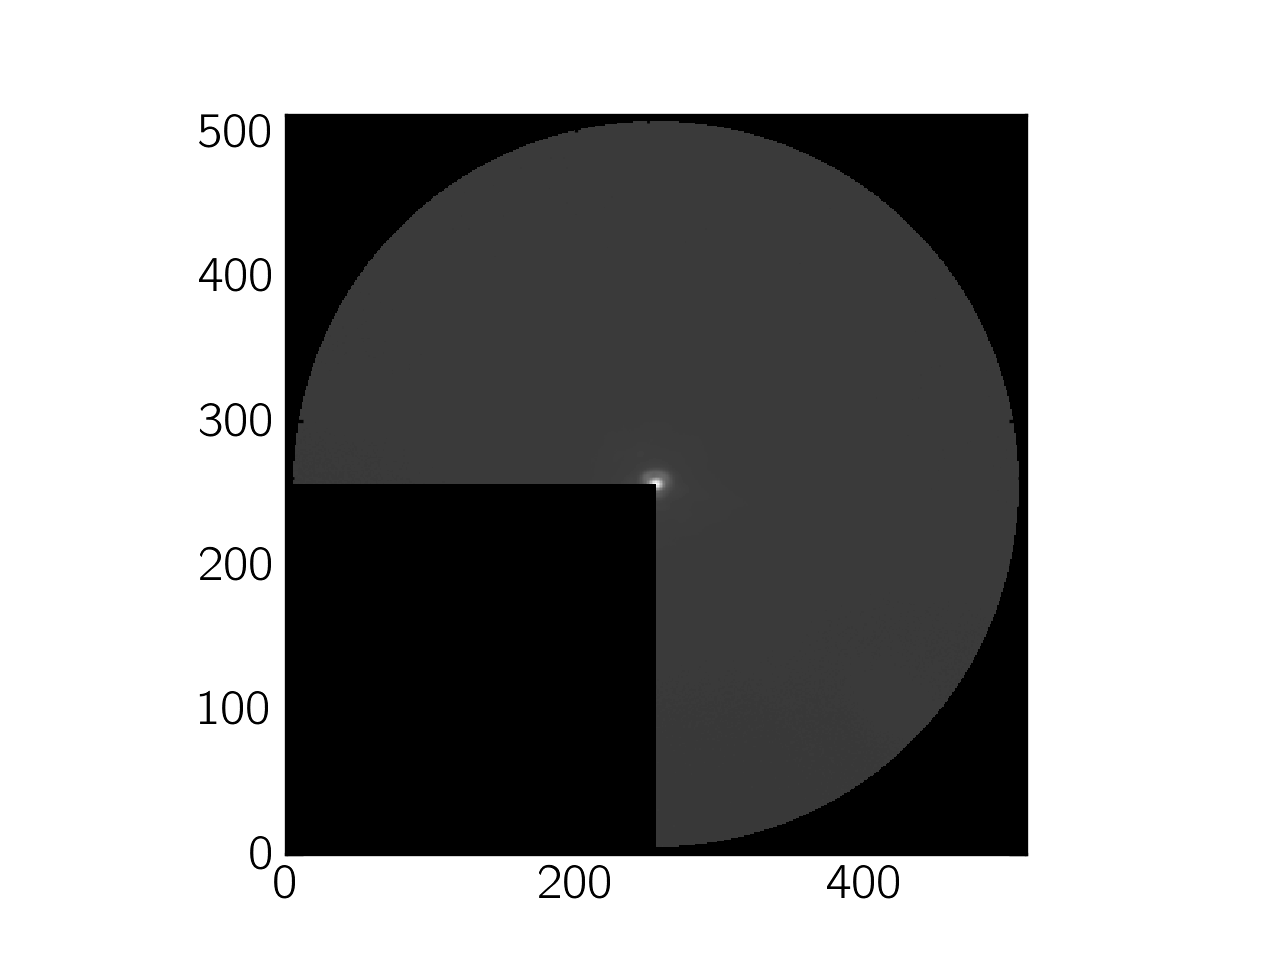

In [3]:
# Open cube of rotated and registered images:
filt = 'z'

imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')
im = imcube.copy()
#im = np.sum(imcube,axis=0)
# make a copy:
im_orig = im.copy()

# Cut out wedge where C is located:
wedgemin = 90
wedgemax = 180
mask = MakeRadialSubtractionMask(im.shape,0,im.shape[0],wedgemin,wedgemax)
boolmask = np.ma.make_mask(mask, shrink=False)

# Mask the outer ring of the image where the corners were rotated:
r, xx, yy = CenteredDistanceMatrix(512, returnmesh = True)
radius = (im.shape[0]-10)*0.5
im[np.where((r > radius))] = 0.0

from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, LinearStretch, LogStretch
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(im)

%matplotlib inline
plt.imshow(mask*im, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch()))

In [4]:
fwhm = Get_MagaoX_FWHM(filt)
aperture_radius = 0.75*fwhm

xca,yca = 255.5,255.5
xcc, ycc = 245.2,242.05
rho_pix = np.sqrt( (xca-xcc)**2 + (yca-ycc)**2 ) # sep in pixels
pixscale = 6 #mas/pixel
rho = rho_pix * pixscale
print( rho*u.mas.to(u.arcsec) )

0.1015644304848349


3.5970769230769224
1822433.3794326242
1827225.85
1821304.5


<IPython.core.display.Javascript object>


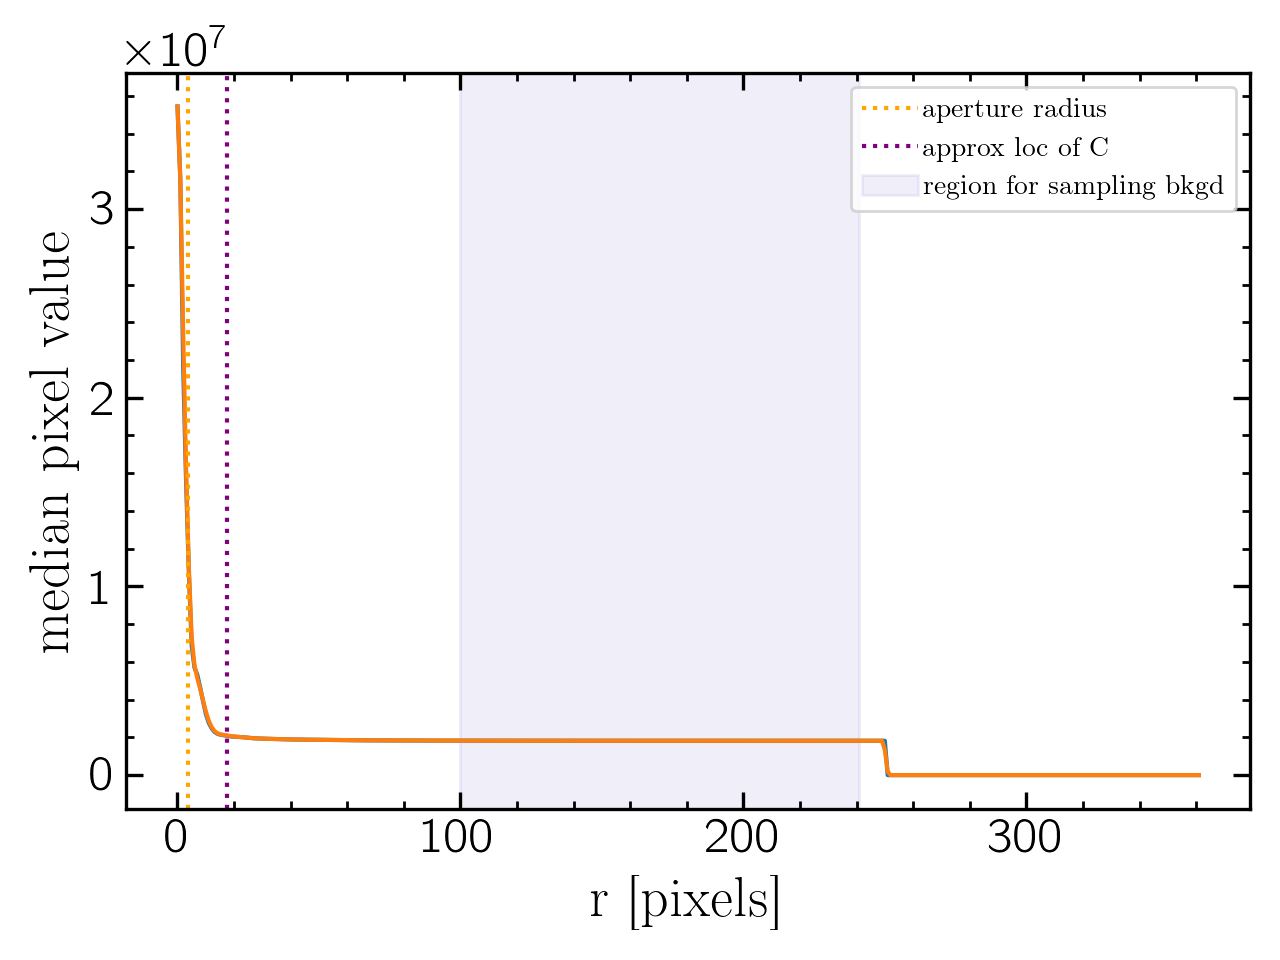

In [6]:
# Get radial profile:
radial_profile = radial_data(im,annulus_width=1,working_mask=boolmask,x=None,y=None,rmax=None)
print(aperture_radius)
xmin, xmax = 100,int(radius) - 10

print(np.mean(radial_profile.median[xmin:xmax]))
print(np.mean(radial_profile.median[xmin-5:xmin+5]))
print(np.mean(radial_profile.median[xmax-5:xmax+5]))

%matplotlib inline
plt.plot(np.arange(len(radial_profile.median)),radial_profile.median)
plt.plot(np.arange(len(radial_profile.median)),radial_profile.mean)
plt.axvline(x=aperture_radius, ls=':',color='orange',label="aperture radius")
plt.axvline(x=17.5, ls=':',color='purple',label="approx loc of C")
plt.axvspan(xmin,xmax,alpha = 0.1, color='slateblue', label='region for sampling bkgd')
plt.xlabel('r [pixels]')
plt.ylabel('median pixel value')
#plt.xlim(0,200)
plt.legend()
plt.tight_layout()

In [7]:
bkgd = np.median(radial_profile.median[xmin:xmax])
imsubbed = im - bkgd
print(bkgd)

1821695.0


0.0


<IPython.core.display.Javascript object>


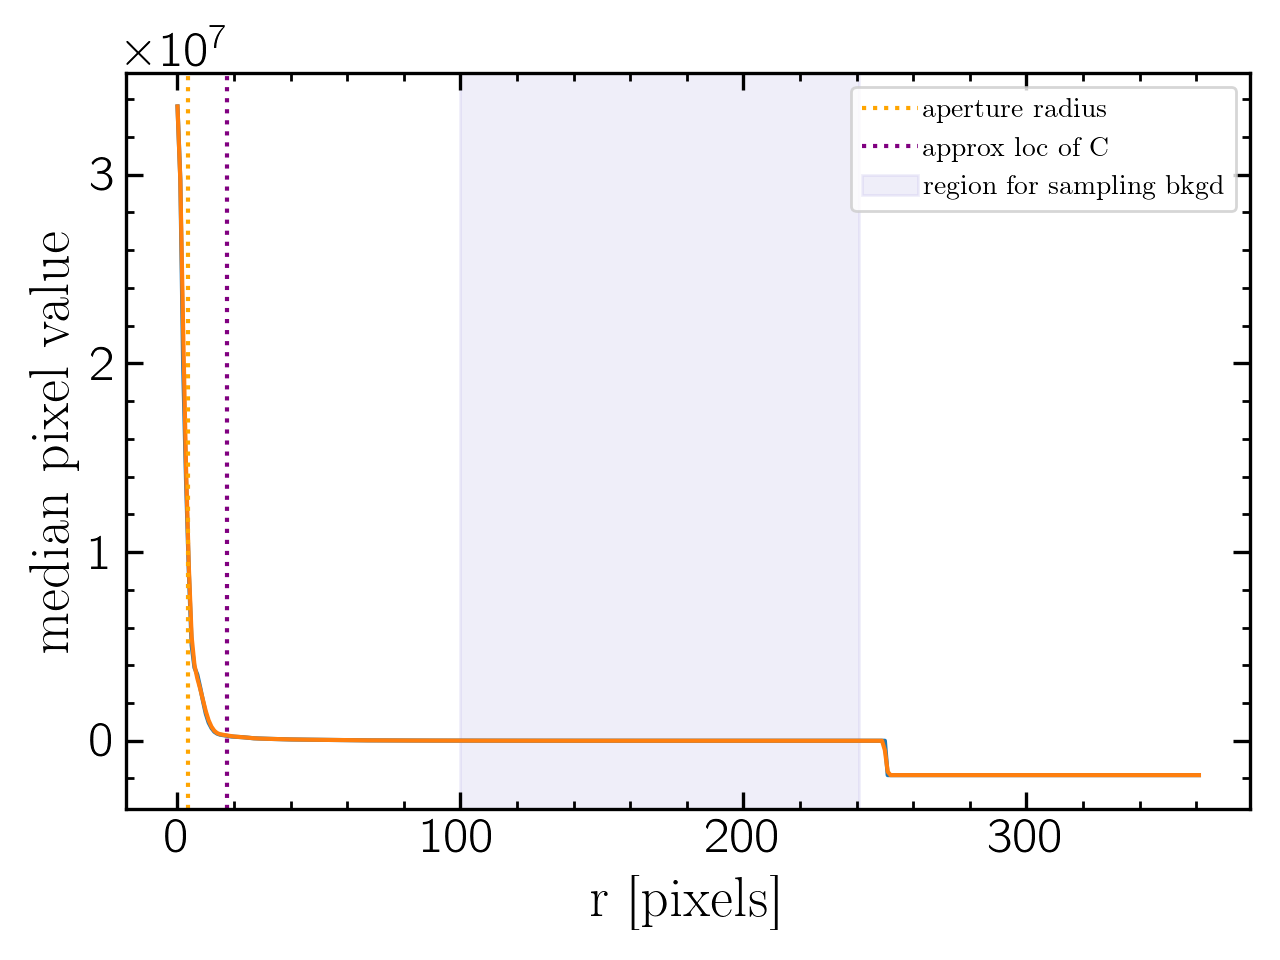

In [8]:
radial_profile2 = radial_data(imsubbed,annulus_width=1,working_mask=boolmask,x=None,y=None,rmax=None)
print(np.median(radial_profile2.median[xmin:xmax]))

%matplotlib notebook
plt.plot(np.arange(len(radial_profile2.median)),radial_profile2.median)
plt.plot(np.arange(len(radial_profile2.median)),radial_profile2.mean)
plt.axvline(x=aperture_radius, ls=':',color='orange',label="aperture radius")
plt.axvline(x=17.5, ls=':',color='purple',label="approx loc of C")
plt.axvspan(xmin,xmax,alpha = 0.1, color='slateblue', label='region for sampling bkgd')
plt.xlabel('r [pixels]')
plt.ylabel('median pixel value')
#plt.xlim(0,200)
plt.legend()
plt.tight_layout()

Median value of starlight at location of C 300817.0


/var/folders/tm/1xdh6wyn1qv7mhy_c10d5c_w0000gn/T/ipykernel_11086/2155528776.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Cs_starlight = np.median(radial_profile2.median[np.int(Cloc - DS):np.int(Cloc + DS)])


<IPython.core.display.Javascript object>


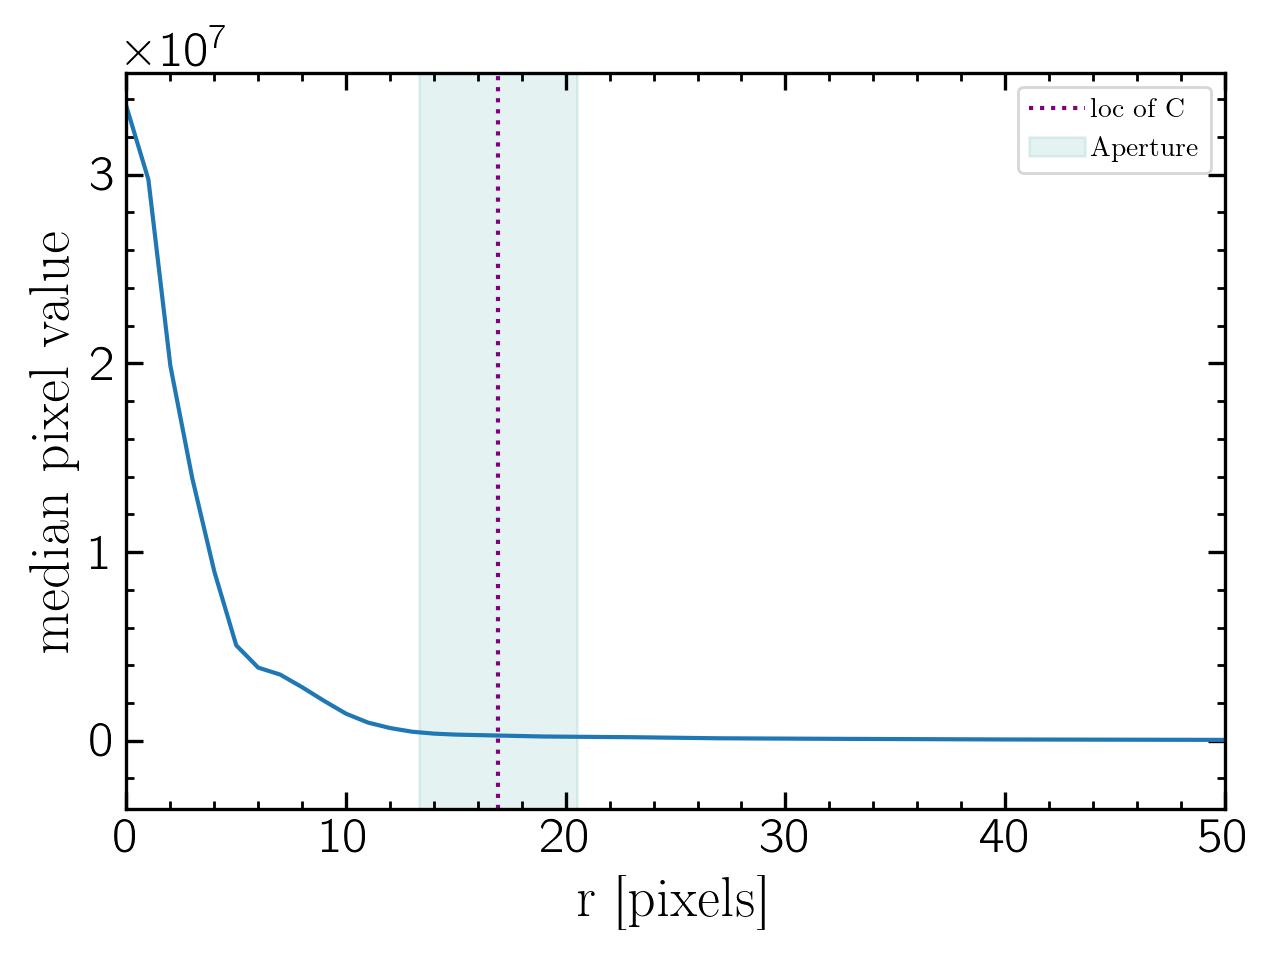

In [9]:
# Get new radial profile:
radial_profile2 = radial_data(imsubbed,annulus_width=1,working_mask=boolmask,x=None,y=None,rmax=None)
Cloc = np.sqrt((xca-xcc)**2 + (yca-ycc)**2)

Apmin,Apmax = Cloc - aperture_radius, Cloc+aperture_radius
DS = 0.9
Cs_starlight = np.median(radial_profile2.median[np.int(Cloc - DS):np.int(Cloc + DS)])

print('Median value of starlight at location of C',Cs_starlight)


%matplotlib inline
plt.plot(np.arange(len(radial_profile2.median)),radial_profile2.median)
#plt.axvline(x=aperture_radius, ls=':',color='orange',label="aperture radius")
#plt.axvline(x=xmax, ls='--',color='purple',label="cutoff")
plt.axvline(x=Cloc, ls=':',color='purple',label="loc of C")
plt.axvspan(Apmin,Apmax,alpha = 0.1, color='teal', label='Aperture')
plt.xlabel('r [pixels]')
plt.ylabel('median pixel value')
plt.xlim(0,50)
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


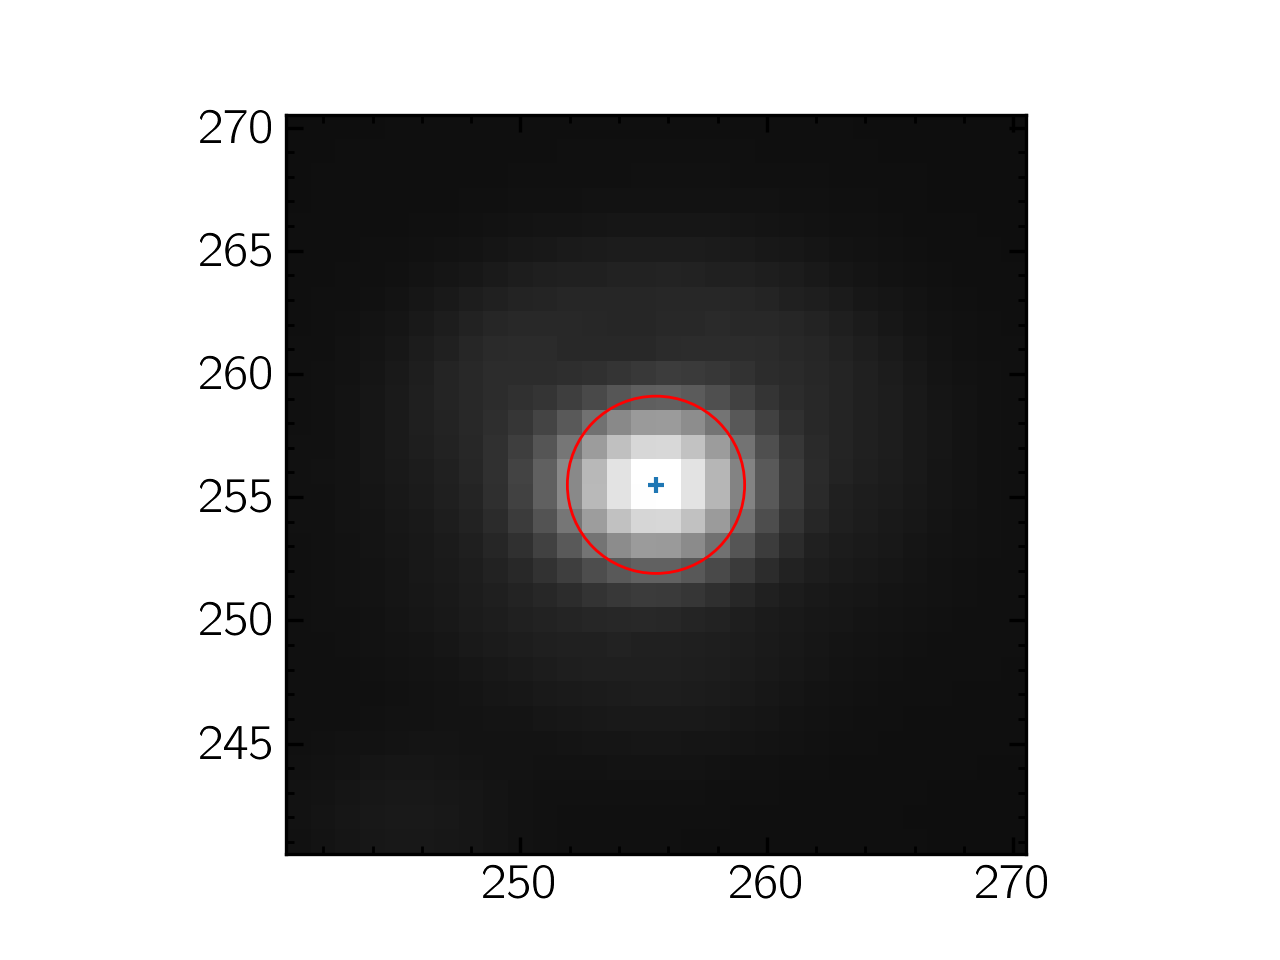

 id xcenter ycenter    aperture_sum  
      pix     pix                    
--- ------- ------- -----------------
  1   255.5   255.5 981206576.5232438


In [10]:
from photutils.aperture import CircularAperture, aperture_photometry

aperture_A = CircularAperture([xca,yca], r=aperture_radius)

A = aperture_photometry(im, aperture_A)

%matplotlib inline
plt.imshow(imsubbed)
plt.scatter(xca,yca,marker='+')
aperture_A.plot(color='red')
plt.xlim(xca-15,xca+15)
plt.ylim(yca-15,yca+15)
print(A)

In [11]:
#### Correct count measurement to account for light outside my aperture:
# Get dr:
dr = np.mean([radial_profile.r[i]-radial_profile.r[i-1] for i in range(1,len(radial_profile.r))])
print(dr)
# Get radial profile within aperture:
ind = np.where(radial_profile.r < aperture_radius)
# Integrate radial profile within aperture: Int(profile*r*dr)
integral_within_aperture = np.sum(radial_profile.median[ind] * radial_profile.r[ind] * dr)

# Get radial profile out to masked outer ring:
ind = np.where(radial_profile.r < xmax)
# Integrate total radial profile:
integral_total_psf = np.sum(radial_profile.median[ind] * radial_profile.r[ind] * dr)

# Get correction factor from aperture to total:
correction_ratio = integral_total_psf / integral_within_aperture
print(integral_within_aperture,integral_total_psf, correction_ratio)

# Correct aperture photometry
A['corrected counts'] = A['aperture_sum'] * correction_ratio

1.0
174332277.25 53464351218.25 306.6807367036215


In [12]:
aperture_c = CircularAperture([xcc,ycc], r=aperture_radius)

C = aperture_photometry(im, aperture_c)
C['corrected counts'] = C['aperture_sum'] * correction_ratio
C

id,xcenter,ycenter,aperture_sum,corrected counts
,pix,pix,,
int64,float64,float64,float64,float64
1,245.21529078100377,242.05523153600686,122885893.10443917,37686736227.751884


In [13]:
A['skysub counts'] = A['aperture_sum'][0] - bkgd*aperture_A.area
C['skysub starsub counts'] = C['aperture_sum'][0] - bkgd*aperture_c.area - Cs_starlight*aperture_c.area

A['mag'] = -2.5*np.log10(A['skysub counts'])
C['mag'] = -2.5*np.log10(C['skysub starsub counts'])
A['mag'] - C['mag']

-3.4852653253467274


# Do All

In [76]:
def GetContrast(imcube, filt, wedgemin = 90, wedgemax = 180, 
                xca = 255.5, yca= 255.5, 
                xcc = 245.215, ycc = 242.055, 
                aperture_radius = None):
    from myastrotools.tools import CenteredDistanceMatrix, MakeRadialSubtractionMask, radial_data
    from photutils.detection import DAOStarFinder
    from photutils.aperture import CircularAperture, aperture_photometry
    
    # Sum cube:
    if imcube.ndim == 3:
        im = np.sum(imcube,axis=0)
    elif imcube.ndim == 2:
        im = imcube
    
    # Cut out wedge where C is located:
    mask = MakeRadialSubtractionMask(im.shape,0,im.shape[0],wedgemin,wedgemax)
    boolmask = np.ma.make_mask(mask, shrink=False)

    # Mask the outer ring of the image where the corners were rotated:
    r, xx, yy = CenteredDistanceMatrix(512, returnmesh = True)
    radius = (im.shape[0]-10)*0.5
    im[np.where((r > radius))] = 0.0
    
    if not aperture_radius:
        fwhm = Get_MagaoX_FWHM(filt)
        aperture_radius = fwhm
    
    # Get radial profile of image:
    radial_profile = radial_data(im,annulus_width=1,working_mask=boolmask,x=None,y=None,rmax=None)
    xmin, xmax = 100,np.int(radius) - 10
    
    # Get background estimate:
    bkgd = np.median(radial_profile.median[xmin:xmax])
    imsubbed = im - bkgd
    
    # Get new radial profile:
    radial_profile2 = radial_data(imsubbed,annulus_width=1,working_mask=boolmask,x=None,y=None,rmax=None)
    # Estimate amount of starlight present at C's location:
    Cloc = np.sqrt((xca-xcc)**2 + (yca-ycc)**2)
    Apmin,Apmax = Cloc - aperture_radius, Cloc+aperture_radius
    DS = 1.0
    Cs_starlight = np.median(radial_profile2.median[np.int(Cloc - DS):np.int(Cloc + DS)])
    
    # Lay an aperture at A and do photometry on original image:
    aperture_A = CircularAperture([xca,yca], r=aperture_radius)
    A = aperture_photometry(im, aperture_A)
    # Repeat for C:
    aperture_c = CircularAperture([xcc,ycc], r=aperture_radius)
    C = aperture_photometry(im, aperture_c)
    
    A['skysub counts'] = A['aperture_sum'][0] - bkgd*aperture_A.area
    C['skysub counts'] = C['aperture_sum'][0] - bkgd*aperture_c.area
    C['skysub starsub counts'] = C['aperture_sum'][0] - bkgd*aperture_c.area - Cs_starlight*aperture_c.area

    A['mag'] = -2.5*np.log10(A['skysub counts'])
    C['mag'] = -2.5*np.log10(C['skysub starsub counts'])
    
    return A, C, A['mag'] - C['mag']

In [77]:
# Open cube of rotated and registered images:
filt = 'z'
imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')

fwhm = Get_MagaoX_FWHM(filt)

Z_Aphot,Z_Cphot, ZCont = GetContrast(imcube, filt, wedgemin = 90, wedgemax = 180, 
                xca = 255.5, yca= 255.5, 
                xcc = 245.21,ycc = 242.05,
                aperture_radius = 0.75*fwhm)
ZCont

-3.499624939972964


In [78]:
# Open cube of rotated and registered images:
filt = 'i'
imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')

fwhm = Get_MagaoX_FWHM(filt)

I_Aphot,I_Cphot, ICont = GetContrast(imcube, filt, wedgemin = 90, wedgemax = 180, 
                xca = 255.5, yca= 255.5, 
                xcc = 245.21,ycc = 242.05, 
                aperture_radius = 0.75*fwhm)
ICont

-3.8890675109872


In [79]:
# Open cube of rotated and registered images:
filt = 'r'
r_imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated.fits')
imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')

fwhm = Get_MagaoX_FWHM(filt)

R_Aphot,R_Cphot, RCont = GetContrast(imcube, filt, wedgemin = 90, wedgemax = 180, 
                xca = 255.5, yca= 255.5, 
                xcc = 245.21,ycc = 242.05, 
                aperture_radius = 0.75*fwhm)
RCont

-4.683483310204686


In [80]:
# Open cube of rotated and registered images:
filt = 'g'
imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')


fwhm = Get_MagaoX_FWHM(filt)

G_Aphot,G_Cphot, GCont = GetContrast(imcube, filt, wedgemin = 90, wedgemax = 180, 
                xca = 255.5, yca= 255.5, 
                xcc = 245.21,ycc = 242.05, 
                aperture_radius = 0.75*fwhm)
GCont

-5.4834633373599075


<IPython.core.display.Javascript object>


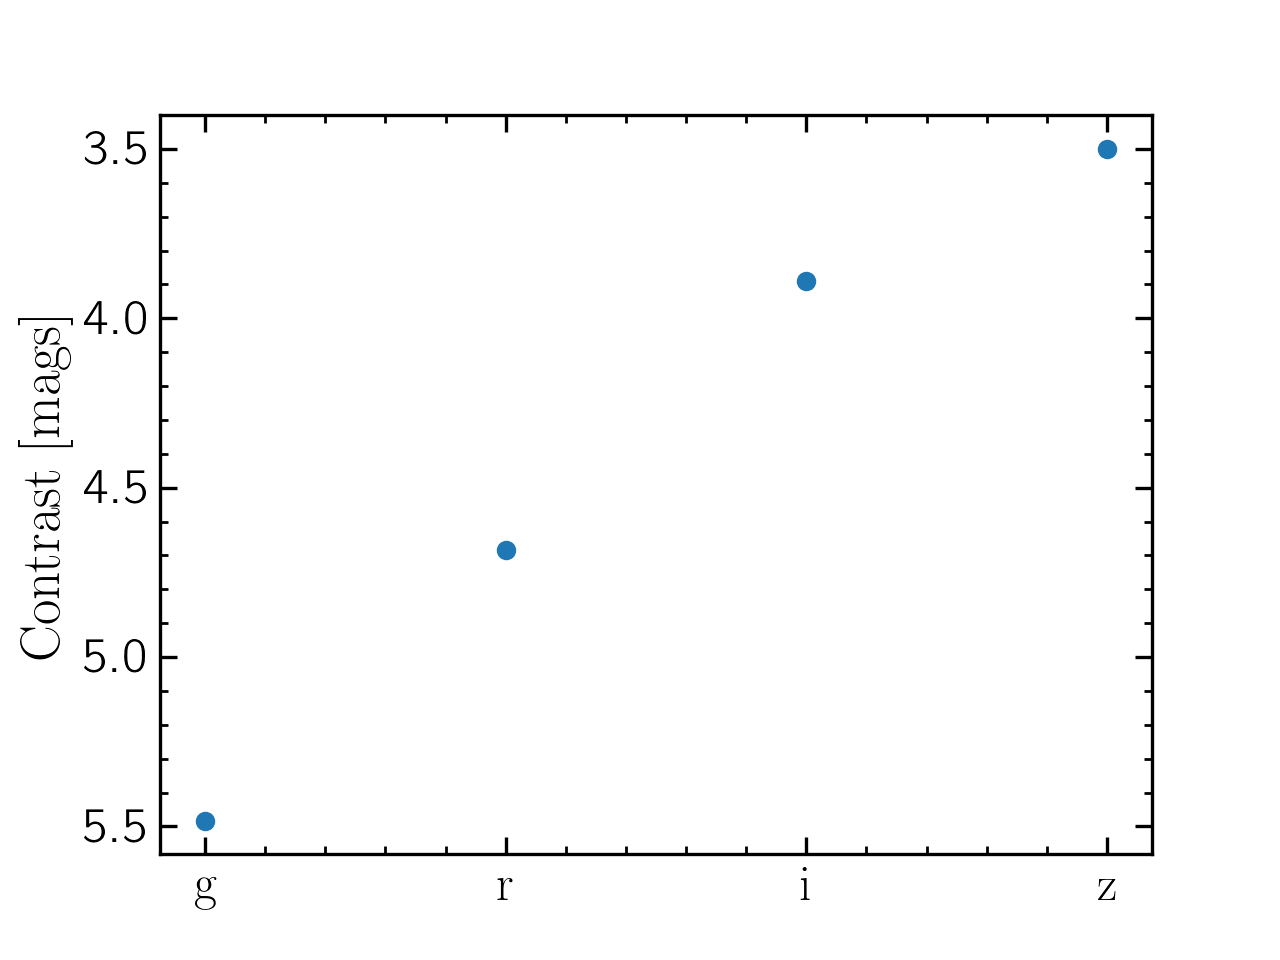

In [17]:
filts = ['g','r','i','z']
conts = np.array([-GCont, -RCont, -ICont, -ZCont])
%matplotlib inline
plt.scatter(filts,conts)
plt.ylabel('Contrast [mags]')
plt.gca().invert_yaxis()

# Uncertainty on photometry:

16.927405080805816 142.58545948043388


<IPython.core.display.Javascript object>


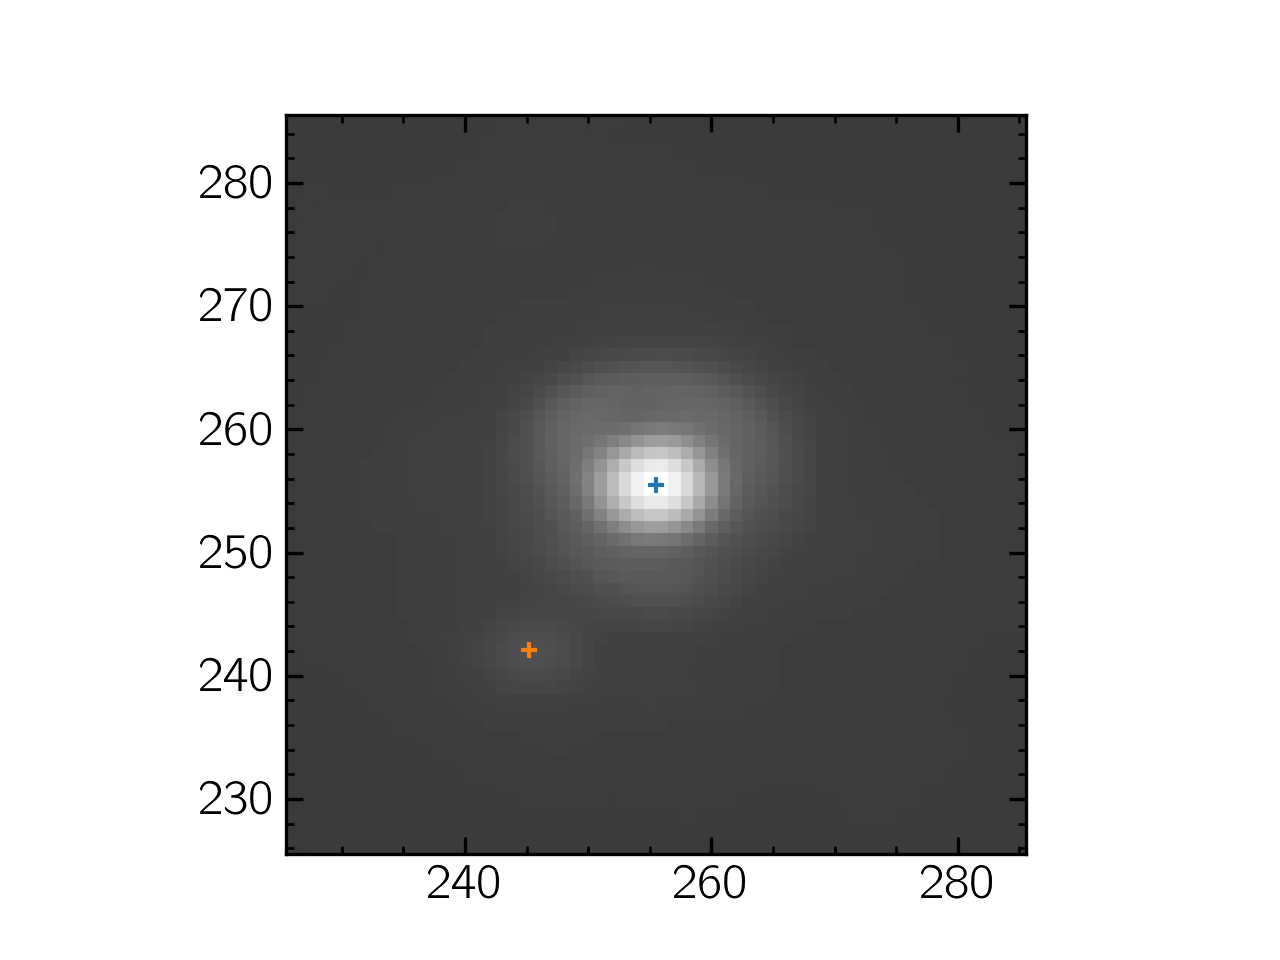

(225.5, 285.5)

In [33]:
sep = np.sqrt((xca - xcc)**2 + (yca - ycc)**2)
pa = (np.degrees(np.arctan2((ycc - yca),(xcc - xca))) + 270) % 360
print(sep,pa)

# Open cube of rotated and registered images:
filt = 'z'
#imcube = fits.getdata(directory+sci+'_'+filt+'_stacked_shifted_rotated.fits')
imcube = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')
im = imcube.copy()

from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, LinearStretch, LogStretch
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(im)

%matplotlib inline
plt.imshow(im, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch()))
plt.scatter(xca,yca,marker='+')
plt.scatter(xcc,ycc,marker='+')
plt.xlim(xca-30,xca+30)
plt.ylim(yca-30,yca+30)

3.5294084841935063
22.0
[175.31273221 191.67636857 208.04000493 224.4036413  240.76727766
 257.13091403 273.49455039 289.85818675 306.22182312 322.58545948
 338.94909584 355.31273221  11.67636857  28.04000493  44.4036413
  60.76727766  77.13091403  93.49455039 109.85818675]


<IPython.core.display.Javascript object>


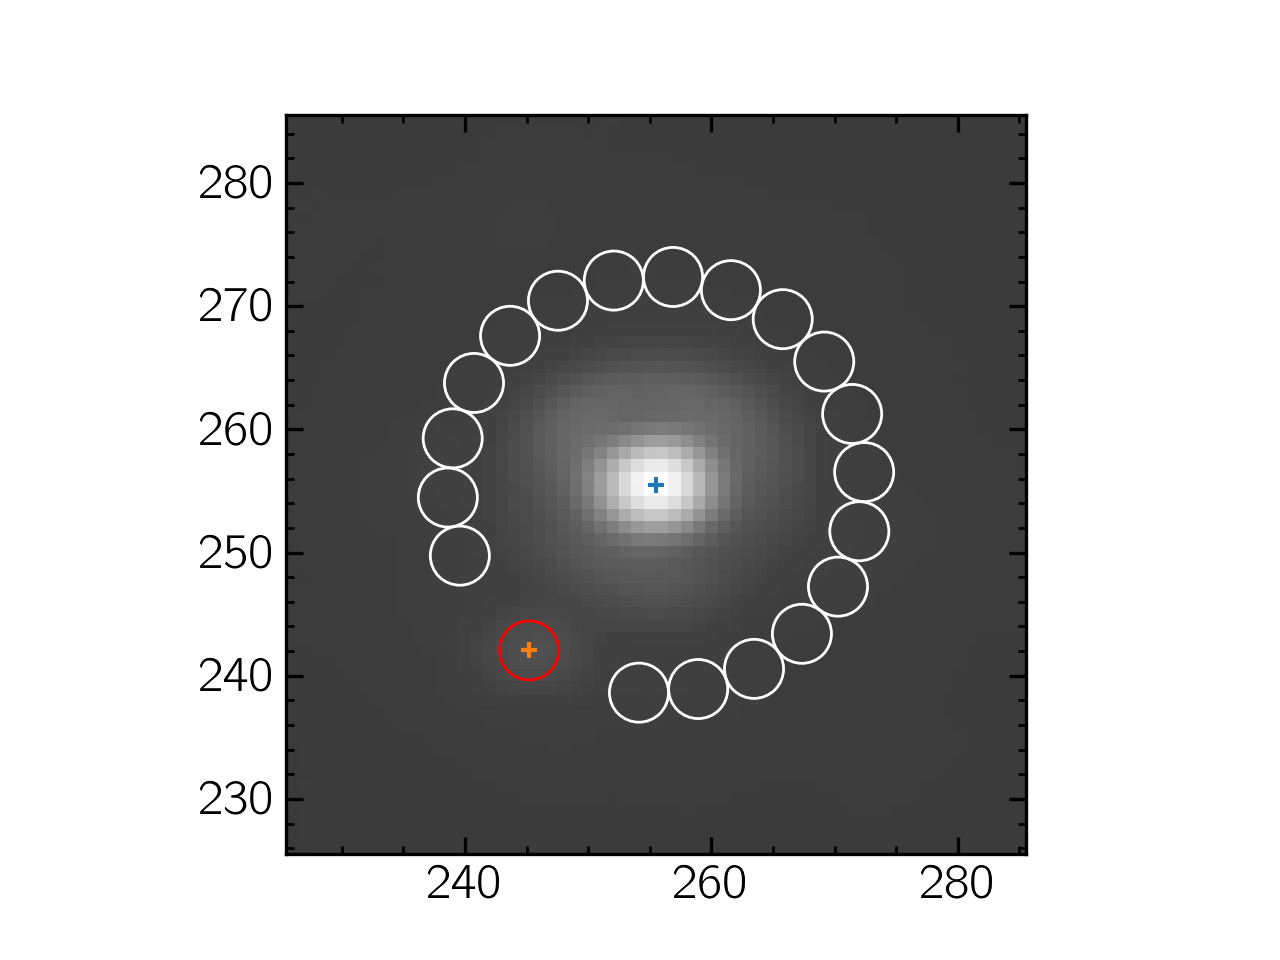

(225.5, 285.5)

In [56]:
filt = 'z'
fwhm = Get_MagaoX_FWHM(filt)
radius = 0.5*fwhm

seplod = sep/fwhm
print(seplod)

from photutils import CircularAperture, aperture_photometry
# Number of 1L/D apertures that can fit on the circumference at separation:
Napers = np.floor(seplod*2*np.pi)
print(Napers)
# Change in angle from center of one aper to the next:
dTheta = 360/Napers
# Create array around circumference, excluding the ones immediately before and after
# where the planet is:
pas = np.arange(pa+2*dTheta,pa+360-dTheta,dTheta)%360
print(pas)
# create emptry container to store results:
noisesums = np.zeros(len(pas))
# for each noise aperture:


xx = sep*np.sin(np.radians((pa)))
yy = sep*np.cos(np.radians((pa)))
xp,yp = xca-xx,yca+yy
aperture = CircularAperture([xp,yp], r=radius)



%matplotlib inline
plt.imshow(im, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch()))
plt.scatter(xca,yca,marker='+')
plt.scatter(xcc,ycc,marker='+')
aperture.plot(color='red')

for i in range(len(pas)):
    xx = sep*np.sin(np.radians((pas[i])))
    yy = sep*np.cos(np.radians((pas[i])))
    xp2,yp2 = xca-xx,yca+yy
    aperture2 = CircularAperture([xp2,yp2], r=radius)
    aperture2.plot(color='white')


plt.xlim(xca-30,xca+30)
plt.ylim(yca-30,yca+30)

20.85026303408751


<IPython.core.display.Javascript object>


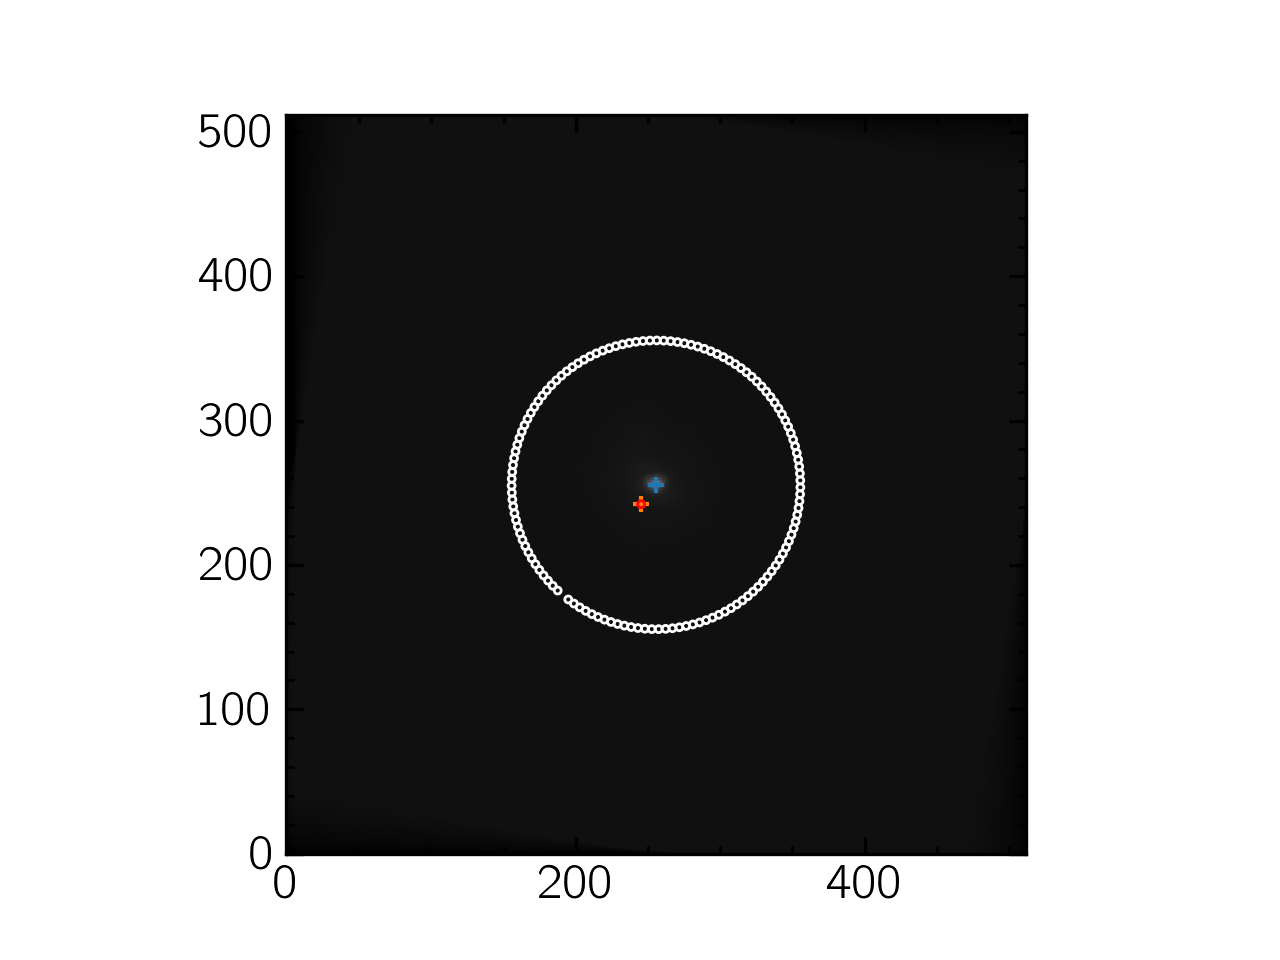

In [130]:
# Noise estimate for A:
bkgdsep = 100
filt = 'z'
fwhm = Get_MagaoX_FWHM(filt)
radius = 0.5*fwhm

bkgdseplod = bkgdsep/fwhm
print(bkgdseplod)

from photutils import CircularAperture, aperture_photometry
# Number of 1L/D apertures that can fit on the circumference at separation:
Napers = np.floor(bkgdseplod*2*np.pi)
# Change in angle from center of one aper to the next:
dTheta = 360/Napers
# Create array around circumference, excluding the ones immediately before and after
# where the planet is:
pas = np.arange(pa,pa+360-dTheta,dTheta)%360
# create emptry container to store results:
noisesums = np.zeros(len(pas))
# for each noise aperture:



%matplotlib inline
plt.imshow(im, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch()))
plt.scatter(xca,yca,marker='+')
plt.scatter(xcc,ycc,marker='+')
aperture.plot(color='red')

for i in range(len(pas)):
    xx = bkgdsep*np.sin(np.radians((pas[i])))
    yy = bkgdsep*np.cos(np.radians((pas[i])))
    xp2,yp2 = xca-xx,yca+yy
    aperture2 = CircularAperture([xp2,yp2], r=radius)
    aperture2.plot(color='white')


#plt.xlim(xca-30,xca+30)
#plt.ylim(yca-30,yca+30)

In [131]:
def getsnr(im, filt, sep, pa):
    fwhm = Get_MagaoX_FWHM(filt)
    radius = 0.5*fwhm
    from photutils import CircularAperture, aperture_photometry
    # Number of 1L/D apertures that can fit on the circumference at separation:
    seplod = sep/fwhm
    Napers = np.floor(seplod*2*np.pi)
    # Change in angle from center of one aper to the next:
    dTheta = 360/Napers
    # Create array around circumference, excluding the ones immediately before and after
    # where the planet is:
    pas = np.arange(pa+2*dTheta,pa+360-dTheta,dTheta)%360
    # create emptry container to store results:
    noisesums = np.zeros(len(pas))
    # for each noise aperture:
    # for each noise aperture:
    for i in range(len(pas)):
        # lay down a photometric aperture at that point:
        xx = sep*np.sin(np.radians((pas[i])))
        yy = sep*np.cos(np.radians((pas[i])))
        xp,yp = xca-xx,yca+yy
        aperture = CircularAperture([xp,yp], r=radius)
        # sum pixels in aperture:
        phot = aperture_photometry(im, aperture)
        # add to noise container:
        noisesums[i] = phot['aperture_sum'][0]
    # the noise value is the std dev of pixel sums in each
    # noise aperture:
    noise = np.std(noisesums)
    # Compute signal of injected planet in signal aperture:
    xx = sep*np.sin(np.radians((pa)))
    yy = sep*np.cos(np.radians((pa)))
    xp,yp = xca-xx,yca+yy
    # Lay down aperture at planet location:
    aperture = CircularAperture([xp,yp], r=radius)
    # compute pixel sum in that location:
    phot = aperture_photometry(im, aperture)
    signal = phot['aperture_sum'][0]
    signal_without_bkgd = signal.copy()
    # compute mean background:
    bkgd = np.mean(noisesums)
    # Eqn 9 in Mawet 2014:
    # xbar1 - xbar2:
    signal = signal - bkgd
    # over s2*sqrt(1+1/n2):
    snr = signal / ( noise * np.sqrt(1+ (1/np.size(pas))) )
    
    # Bkgd noise estimate for A:
    bkgdsep = 100
    bkgdseplod = bkgdsep/fwhm

    # Number of 1L/D apertures that can fit on the circumference at separation:
    Napers = np.floor(bkgdseplod*2*np.pi)
    # Change in angle from center of one aper to the next:
    dTheta = 360/Napers
    # Create array around circumference, excluding the ones immediately before and after
    # where the planet is:
    pas2 = np.arange(pa,pa+360-dTheta,dTheta)%360
    # create emptry container to store results:
    noisesums = np.zeros(len(pas2))
    # for each noise aperture
    for i in range(len(pas2)):
        xx = bkgdsep*np.sin(np.radians((pas2[i])))
        yy = bkgdsep*np.cos(np.radians((pas2[i])))
        xp2,yp2 = xca-xx,yca+yy
        aperture2 = CircularAperture([xp2,yp2], r=radius)
        phot = aperture_photometry(im, aperture2)
        # add to noise container:
        noisesums[i] = phot['aperture_sum'][0]
    bkgdnoise = np.std(noisesums)

    
    
    return snr, signal, ( noise * np.sqrt(1+ (1/np.size(pas))) ), ( bkgdnoise * np.sqrt(1+ (1/np.size(pas2))) )


In [132]:
# Open cube of rotated and registered images:
filt = 'z'
im = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')
Zsnr = getsnr(im, 'z', sep, pa)

filt = 'i'
im = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')
Isnr = getsnr(im, 'i', sep, pa)

filt = 'r'
im = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')
Rsnr = getsnr(im, 'r', sep, pa)

filt = 'g'
im = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')
Gsnr = getsnr(im, 'g', sep, pa)

Zsnr, Isnr, Rsnr, Gsnr

((16.740151415243012,
  19979648.09974341,
  1193516.570080162,
  62642.643464572095),
 (9.4904085622554, 26288941.83506895, 2770053.7508599493, 88966.63924427696),
 (6.832700188980727, 13886330.569426581, 2032334.243469577, 67842.20532789393),
 (2.0536952922638148,
  427900.20490013994,
  208356.22816686696,
  5362.44392455107))

In [133]:
out = {'zSNR':Zsnr,'iSNR':Isnr,'rSNR':Rsnr,'gSNR':Gsnr}
pickle.dump(out,open('Magao-X-snr.pkl','wb'))

In [134]:
G_Cphot['mag'] - -2.5*np.log10(G_Cphot['skysub starsub counts'][0] / Gsnr[0])

-0.7813400189113278


In [135]:
-2.5*np.log10(Gsnr[1]) - -2.5*np.log10(Gsnr[2])

-0.7813400189113278

In [139]:
from myastrotools.tools import MonteCarloIt
Azmag = -2.5*np.log10(Z_Aphot['skysub counts'])
AZfluxarray = MonteCarloIt([Z_Aphot['skysub counts'],Zsnr[3]])
Zfluxarray = MonteCarloIt([Z_Cphot['skysub starsub counts'],Zsnr[2]])
Zcont_array = np.array([np.mean((-2.5*np.log10(AZfluxarray) - (-2.5*np.log10(Zfluxarray)))),
                        np.std((-2.5*np.log10(AZfluxarray) - (-2.5*np.log10(Zfluxarray))))])

Aimag = -2.5*np.log10(I_Aphot['skysub counts'])
AIfluxarray = MonteCarloIt([I_Aphot['skysub counts'],Isnr[3]])
Ifluxarray = MonteCarloIt([I_Cphot['skysub starsub counts'],Isnr[2]])
Icont_array = np.array([np.mean((-2.5*np.log10(AIfluxarray) - (-2.5*np.log10(Ifluxarray)))),
                        np.std((-2.5*np.log10(AIfluxarray) - (-2.5*np.log10(Ifluxarray))))])

Armag = -2.5*np.log10(R_Aphot['skysub counts'])
Rfluxarray = MonteCarloIt([R_Cphot['skysub starsub counts'],Rsnr[2]])
Rcont_array = np.array([np.mean(Armag - (-2.5*np.log10(Rfluxarray))),
                        np.std(Armag - (-2.5*np.log10(Rfluxarray)))])

Agmag = -2.5*np.log10(G_Aphot['skysub counts'])
Gfluxarray = MonteCarloIt([G_Cphot['skysub starsub counts'],Gsnr[2]])
Gcont_array = np.array([np.nanmean(Agmag - (-2.5*np.log10(Gfluxarray))),
                        np.nanstd(Agmag - (-2.5*np.log10(Gfluxarray)))])

print(Zcont_array, ZCont[0])
print(Icont_array, ICont[0])
print(Rcont_array, RCont[0])
print(Gcont_array, GCont[0])

[-3.50069163  0.03621936] -3.499624939972964
[-3.89067377  0.0598883 ] -3.8890675109872
[-4.68750758  0.09421891] -4.683483310204686
[-5.53727496  0.36070408] -5.4834633373599075


<ipython-input-139-2725a90cbd35>:21: RuntimeWarning: invalid value encountered in log10
  Gcont_array = np.array([np.nanmean(Agmag - (-2.5*np.log10(Gfluxarray))),
<ipython-input-139-2725a90cbd35>:22: RuntimeWarning: invalid value encountered in log10
  np.nanstd(Agmag - (-2.5*np.log10(Gfluxarray)))])


In [140]:
out = {'zCont':Zcont_array,'iCont':Icont_array,'rCont':Rcont_array,'gCont':Gcont_array}
pickle.dump(out,open('Magao-X-contrasts.pkl','wb'))